In [1]:
import splitfolders
splitfolders.ratio('dataset', output="output", seed=1337, ratio=(.8, 0.2)) 

Copying files: 500 files [00:01, 306.38 files/s]


In [2]:
# Define our example directories and files
base_dir = 'output'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'val')

# Nasi Goreng
train_nasigoreng_dir = os.path.join(train_dir, 'Nasi Goreng') 
validation_nasigoreng_dir = os.path.join(validation_dir, 'Nasi Goreng') 

# Nasi Padang
train_nasipadang_dir = os.path.join(train_dir, 'Nasi Padang') 
validation_nasipadang_dir = os.path.join(validation_dir, 'Nasi Padang') 

# Bakso
train_bakso_dir = os.path.join(train_dir, 'Bakso') 
validation_bakso_dir = os.path.join(validation_dir, 'Bakso') 

# Sate
train_sate_dir = os.path.join(train_dir, 'Sate') 
validation_sate_dir = os.path.join(validation_dir, 'Sate') 

# Burger
train_burger_dir = os.path.join(train_dir, 'Burger') 
validation_burger_dir = os.path.join(validation_dir, 'Burger') 

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [4]:
import tensorflow as tf

'''Creates a CNN with 4 convolutional layers'''
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# model = tf.keras.applications.MobileNetV2(
#   input_shape=(224, 224, 3),
#   alpha=0.5,
#   include_top=False,
#   weights="imagenet",
#   input_tensor=None,
#   pooling='max',
#   classes=5,
#   classifier_activation="softmax"
# )

# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])


'Creates a CNN with 4 convolutional layers'

In [5]:
import tensorflow_hub as hub

mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224,224,3))
mobile_net_layers.trainable = False

model = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(256,activation='relu'),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(5,activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['acc'])


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2,602,693
Trainable params: 344,709
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:

# Train the model
EPOCHS = 10
history = model.fit(
      train_generator,
      steps_per_epoch=16,  # 80 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=4,  # 20 images = batch_size * steps
      verbose=2)
      
model.save('model.h5')

Epoch 1/10
16/16 - 32s - loss: 1.0947 - acc: 0.6156 - val_loss: 0.4411 - val_acc: 0.8125 - 32s/epoch - 2s/step
Epoch 2/10
16/16 - 24s - loss: 0.2999 - acc: 0.8906 - val_loss: 0.1834 - val_acc: 0.9375 - 24s/epoch - 2s/step
Epoch 3/10
16/16 - 22s - loss: 0.1707 - acc: 0.9312 - val_loss: 0.0974 - val_acc: 0.9875 - 22s/epoch - 1s/step
Epoch 4/10
16/16 - 23s - loss: 0.1422 - acc: 0.9469 - val_loss: 0.0813 - val_acc: 0.9750 - 23s/epoch - 1s/step
Epoch 5/10
16/16 - 22s - loss: 0.0948 - acc: 0.9625 - val_loss: 0.1175 - val_acc: 0.9500 - 22s/epoch - 1s/step
Epoch 6/10
16/16 - 20s - loss: 0.1039 - acc: 0.9594 - val_loss: 0.1260 - val_acc: 0.9500 - 20s/epoch - 1s/step
Epoch 7/10
16/16 - 27s - loss: 0.0853 - acc: 0.9719 - val_loss: 0.1088 - val_acc: 0.9625 - 27s/epoch - 2s/step
Epoch 8/10
16/16 - 22s - loss: 0.0847 - acc: 0.9719 - val_loss: 0.0418 - val_acc: 0.9750 - 22s/epoch - 1s/step
Epoch 9/10
16/16 - 22s - loss: 0.0773 - acc: 0.9750 - val_loss: 0.1293 - val_acc: 0.9500 - 22s/epoch - 1s/step
E

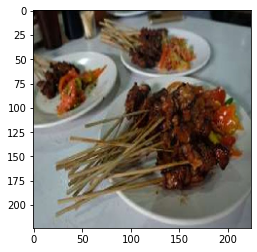

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "dataset/16364352016-0910-16474600-2-p.jpg"
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

In [23]:
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model = tf.keras.models.load_model(
       ('model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)


In [25]:
print(prediction)
pred=prediction.argmax()

if pred==0:
    x = 'Bakso'
elif pred==1:
    x = 'Burger'
elif pred==2:
    x = 'Nasi Goreng'
elif pred==3:
    x = 'Nasi Padang'
elif pred==4:
    x = 'Sate'

print('prediction: ', x)

[[2.7786419e-02 2.4303608e-02 1.4119176e-04 8.4952591e-04 9.4691926e-01]]
prediction:  Sate
